In [ ]:
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

In [3]:
# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

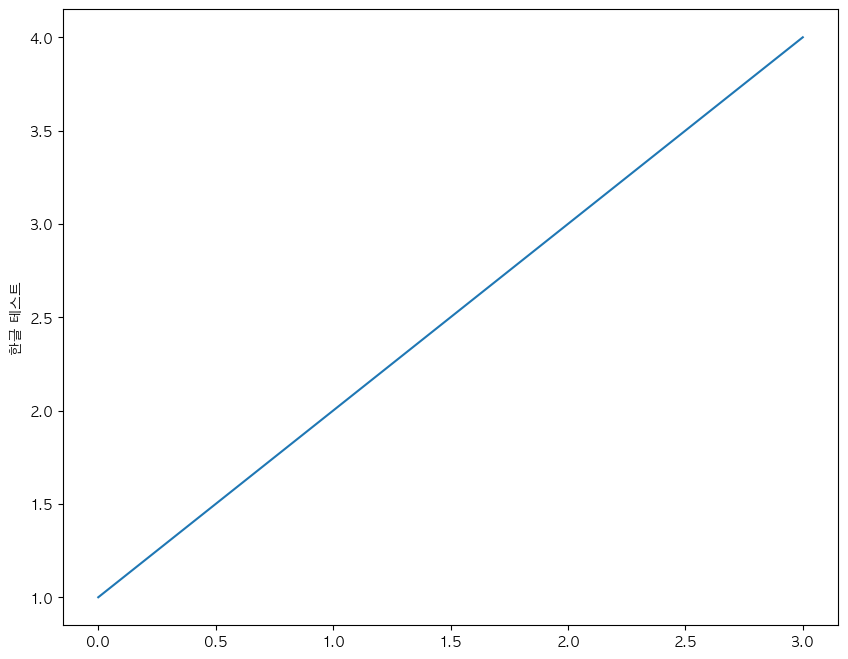

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

In [5]:
# 골드이상 사용자중 해지방어 프로모션 사용자 비율 확인
dfs_promo_query = '''
SELECT F1.DT
     , DATE_FORMAT(F1.DT,'%Y-%m') AS YM
     , DATE_FORMAT(F1.DT,'%Y%m%d') AS log_date     
     , F1.OUT_PROD_CNT
     , F1.SELF_OUT_PROD_CNT
     , F1.TRGT_PROD_CNT
     , F1.at_pay_trgt_prod_cnt
     , CAST(F2.NEW_PROMO_PROD_CNT as DOUBLE)/CAST(F1.at_pay_trgt_prod_cnt + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 AS NEW_PROMO_PROD_RATIO
     , cast(F1.SELF_OUT_PROD_CNT as double)/cast(F1.at_pay_trgt_prod_cnt as double)*100 as SELF_OUT_PROD_RATIO_2
     , F2.NEW_PROMO_PROD_CNT
     , F2.NEW_PROMO_PROD_CNT_2 
     , F1.SELF_OUT_PROD_RATIO
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)/CAST(F1.TRGT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 AS NEW_SELF_OUT_PROD_RATIO
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)/CAST(F1.TRGT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 - F1.SELF_OUT_PROD_RATIO AS DIFF_OUT_RATIO
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT_2 AS DOUBLE)/CAST(F1.TRGT_PROD_CNT + F2.NEW_PROMO_PROD_CNT_2 AS DOUBLE)*100 AS NEW_SELF_OUT_PROD_RATIO_2
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)/CAST(F1.at_pay_trgt_prod_cnt + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 AS NEW_SELF_OUT_PROD_RATIO_3
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)/CAST(F1.at_pay_trgt_prod_cnt + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 - F1.SELF_OUT_PROD_RATIO AS DIFF_OUT_RATIO_3
FROM(
    SELECT A.DT         
         , COUNT(DISTINCT A.BUY_NO) AS OUT_PROD_CNT
         , COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201),A.BUY_NO)) AS SELF_OUT_PROD_CNT
         , COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201,3300, 3301, 3903, 3902, 3900) OR at_pay_trgt_yn = 1,A.BUY_NO)) AS TRGT_PROD_CNT
         , CAST(COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201),A.BUY_NO)) AS DOUBLE)/CAST(COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201,3300, 3301, 3903, 3902, 3900) OR at_pay_trgt_yn = 1,A.BUY_NO)) AS DOUBLE)*100 AS SELF_OUT_PROD_RATIO
         , COUNT(DISTINCT IF(at_pay_trgt_yn = 1,A.BUY_NO)) AS at_pay_trgt_prod_cnt
    FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT A 
    JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD B  ON (A.PROD_ID = B.PROD_ID)
    WHERE A.LOG_DATE BETWEEN CAST('20240101' AS VARCHAR(8)) AND CAST('20250227' AS VARCHAR(8)) 
    AND DATE_FORMAT(A.DT,'%Y%m%d') BETWEEN CAST('20240101' AS VARCHAR(8)) AND CAST('20250227' AS VARCHAR(8)) 
    AND A.PF_YN = 1 -- 유료
    AND DATE(A.VLD_STRT_DATE) <= DATE(A.VLD_END_DATE)
    AND B.PROD_ATTR_CD NOT IN (10040, 10050)
    AND B.PROD_SELL_PRT_CD = 60000 -- B2C
    AND B.PROD_PRT_CD IN ( 20000, 20010 )
    AND AT_BUY_CNT > 11
    GROUP BY 1
) F1
LEFT JOIN(
    SELECT T1.DT
         , COUNT(DISTINCT T1.BUY_NO) AS NEW_PROMO_PROD_CNT    
         , COUNT(DISTINCT IF(PROMO_NM LIKE '첫달 100원 + %',T1.BUY_NO)) AS NEW_PROMO_PROD_CNT_2    
    FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
    JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T2 ON (T1.PROMO_ID = T2.PROMO_ID)
    JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.SBY_BUY_HIST T3 ON (T1.BUY_NO = T3.BUY_NO)
    WHERE LOG_DATE BETWEEN '20240101' AND '20250227'
    AND T2.PROMO_GRP_CD = 41 -- 해지방어프로모션
    AND T1.PROD_JOIN_PRT_CD NOT IN (9999)
    AND T3.AUTO_BUY_CO = T3.PROMO_FIRST_APPLC_PTIME /* 해지방어 프로모션 시작 상품 */
    AND AT_BUY_CNT > 11
    GROUP BY 1
) F2 ON F1.DT = F2.DT
ORDER BY 2,1
'''

cur.execute(dfs_promo_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

dfs_promo_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
dfs_promo_df.head()

,dt,YM,log_date,out_prod_cnt,self_out_prod_cnt,trgt_prod_cnt,at_pay_trgt_prod_cnt,NEW_PROMO_PROD_RATIO,SELF_OUT_PROD_RATIO_2,new_promo_prod_cnt,new_promo_prod_cnt_2,self_out_prod_ratio,NEW_SELF_OUT_PROD_RATIO,DIFF_OUT_RATIO,NEW_SELF_OUT_PROD_RATIO_2,NEW_SELF_OUT_PROD_RATIO_3,DIFF_OUT_RATIO_3
0,2024-01-01,2024-01,20240101,2919927,2021,117932,115880,0.553529,1.744046,645,0,1.713699,2.248328,0.534629,1.713699,2.287921,0.574222
1,2024-01-02,2024-01,20240102,2918353,1829,96740,94873,0.753193,1.927840,720,0,1.890635,2.615432,0.724797,1.890635,2.666513,0.775879
2,2024-01-03,2024-01,20240103,2917873,1193,53215,51988,1.266736,2.294760,667,0,2.241849,3.451988,1.210139,2.241849,3.532428,1.290579
3,2024-01-04,2024-01,20240104,2918152,2058,114394,112312,0.281455,1.832395,317,0,1.799045,2.070420,0.271375,1.799045,2.108693,0.309648
4,2024-01-05,2024-01,20240105,2916957,1977,115327,113306,0.629692,1.744833,718,0,1.714256,2.322375,0.608119,1.714256,2.363538,0.649282


In [6]:
# dt를 datetime 형식으로 변환
dfs_promo_df['dt'] = pd.to_datetime(dfs_promo_df['dt'])

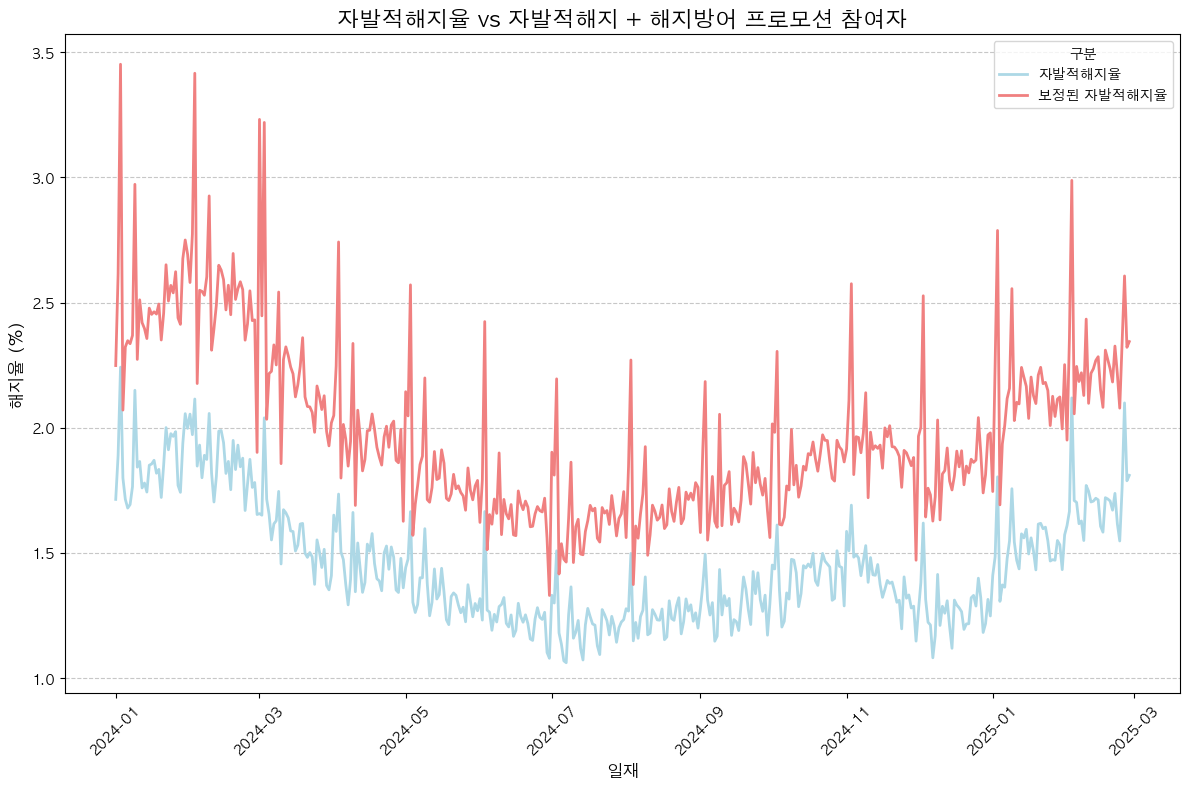

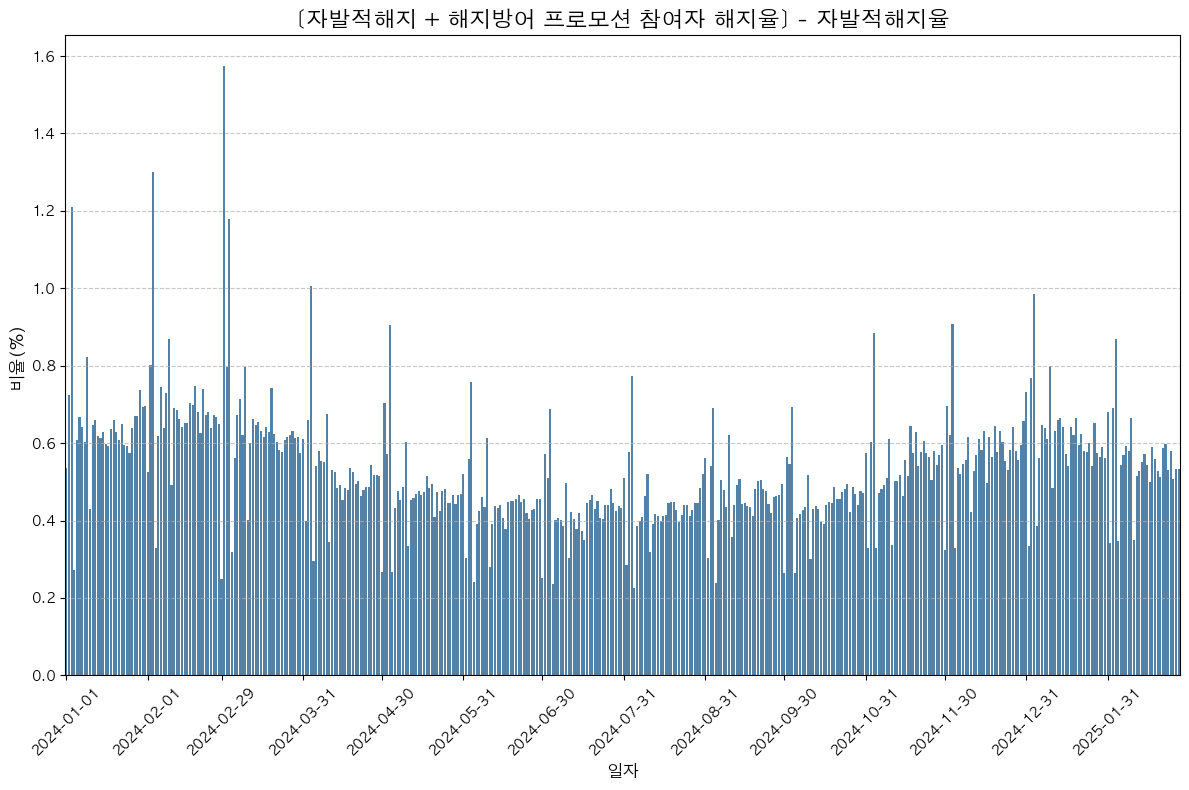

In [7]:
## 기존 마케팅 기준 해지율( 자발적해지상품/[자동결제상품건수 + 자발적해지상품 + 기타해지상품] )
# 그래프 생성
plt.figure(figsize=(12, 8))

# SELF_OUT_PROD_RATIO 라인 플롯
sns.lineplot(data=dfs_promo_df, x='dt', y='self_out_prod_ratio', label='자발적해지율', color='lightblue', linewidth=2)

# NEW_SELF_OUT_PROD_RATIO 라인 플롯
sns.lineplot(data=dfs_promo_df, x='dt', y='NEW_SELF_OUT_PROD_RATIO', label='보정된 자발적해지율', color='lightcoral', linewidth=2)

# 그래프 제목 및 레이블 설정
plt.title('자발적해지율 vs 자발적해지 + 해지방어 프로모션 참여자', fontsize=16)
plt.xlabel('일재', fontsize=12)
plt.ylabel('해지율 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='구분', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()



# 그래프 생성
plt.figure(figsize=(12, 8))

# Bar plot 생성 (색상을 어둡게 설정)
sns.barplot(data=dfs_promo_df, x='dt', y='DIFF_OUT_RATIO', color='steelblue')

# x축 레이블을 매월 1일만 표시
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 매월 1일
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 날짜 형식 설정
plt.xticks(rotation=45)  # x축 레이블 45도 회전

# 그래프 제목 및 레이블 설정
plt.title('[자발적해지 + 해지방어 프로모션 참여자 해지율] - 자발적해지율', fontsize=16)
plt.xlabel('일자', fontsize=12)
plt.ylabel('비율(%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

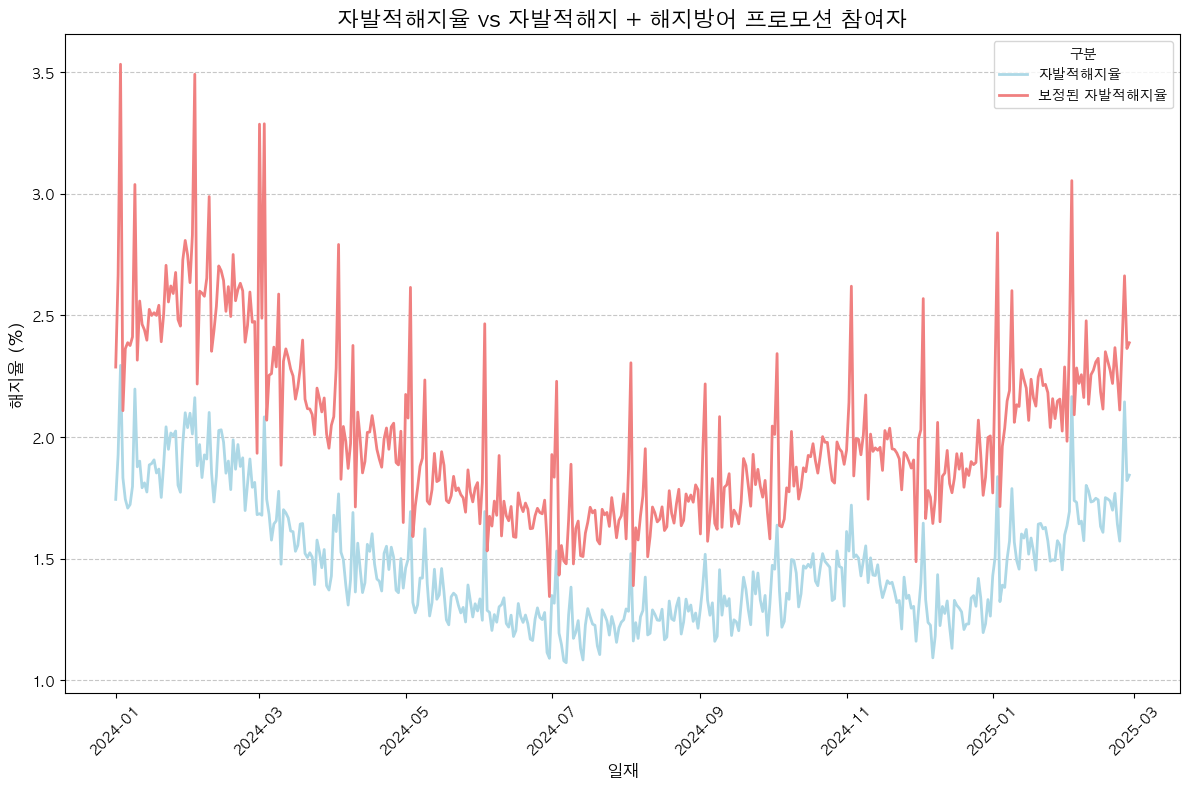

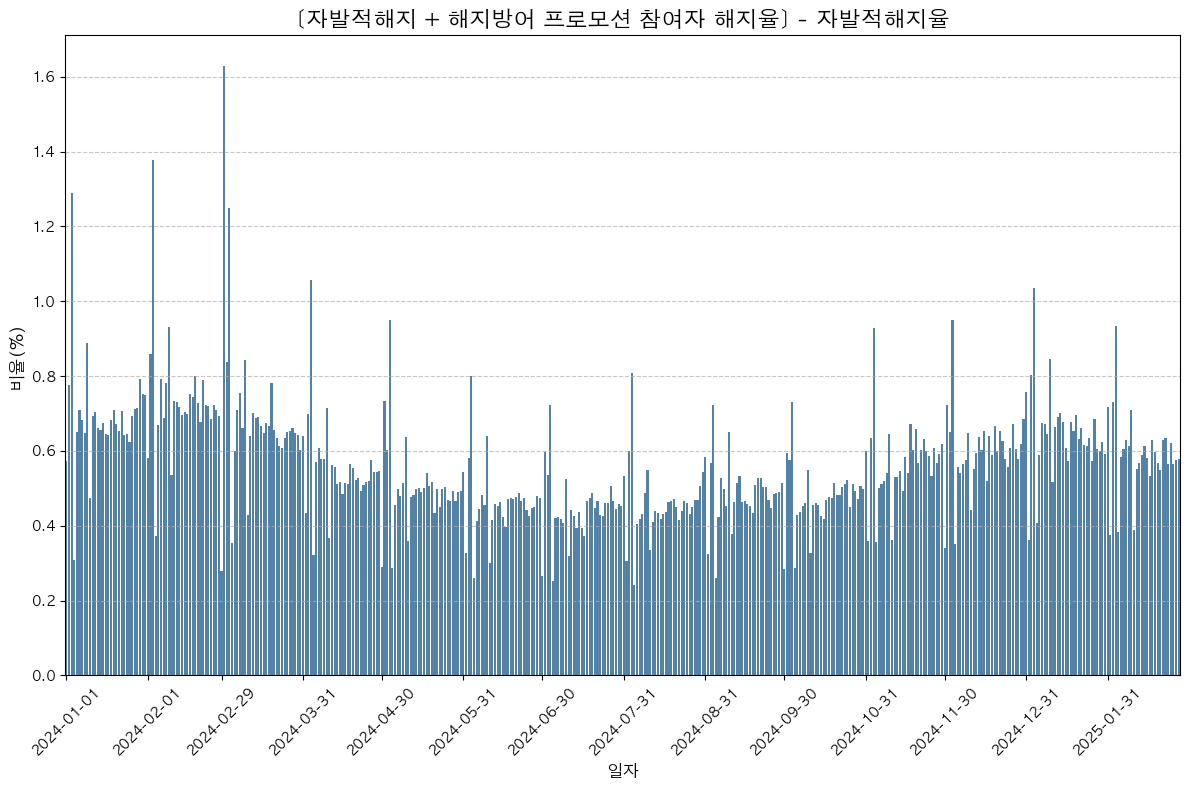

In [8]:
## 태블로 기존 마케팅 기준 해지율( 자발적해지상품/자동결제상품건수 )
# 그래프 생성
plt.figure(figsize=(12, 8))

# SELF_OUT_PROD_RATIO 라인 플롯
sns.lineplot(data=dfs_promo_df, x='dt', y='SELF_OUT_PROD_RATIO_2', label='자발적해지율', color='lightblue', linewidth=2)

# NEW_SELF_OUT_PROD_RATIO 라인 플롯
sns.lineplot(data=dfs_promo_df, x='dt', y='NEW_SELF_OUT_PROD_RATIO_3', label='보정된 자발적해지율', color='lightcoral', linewidth=2)

# 그래프 제목 및 레이블 설정
plt.title('자발적해지율 vs 자발적해지 + 해지방어 프로모션 참여자', fontsize=16)
plt.xlabel('일재', fontsize=12)
plt.ylabel('해지율 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='구분', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()


# 그래프 생성
plt.figure(figsize=(12, 8))

# Bar plot 생성 (색상을 어둡게 설정)
sns.barplot(data=dfs_promo_df, x='dt', y='DIFF_OUT_RATIO_3', color='steelblue')

# x축 레이블을 매월 1일만 표시
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 매월 1일
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 날짜 형식 설정
plt.xticks(rotation=45)  # x축 레이블 45도 회전

# 그래프 제목 및 레이블 설정
plt.title('[자발적해지 + 해지방어 프로모션 참여자 해지율] - 자발적해지율', fontsize=16)
plt.xlabel('일자', fontsize=12)
plt.ylabel('비율(%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

In [12]:
# 'DT' 열을 datetime 형식으로 변환
dfs_promo_df['dt'] = pd.to_datetime(dfs_promo_df['dt'])

# 'YM' 열이 없으면 생성 (연월)
dfs_promo_df['YM'] = dfs_promo_df['dt'].dt.to_period('M').astype(str)

# 월간 평균 계산
monthly_avg = dfs_promo_df.groupby('YM')[['DIFF_OUT_RATIO_3', 'DIFF_OUT_RATIO']].mean().reset_index()

# 피벗 테이블 생성
pivot_table = monthly_avg.pivot_table(index='YM', values=['DIFF_OUT_RATIO_3', 'DIFF_OUT_RATIO'])

# 결과 출력
print(pivot_table)

# 월간 평균 계산
monthly_avg = dfs_promo_df.groupby('YM')[['SELF_OUT_PROD_RATIO_2','NEW_SELF_OUT_PROD_RATIO_3', 'DIFF_OUT_RATIO_3']].mean().reset_index()

# 피벗 테이블 생성
pivot_table = monthly_avg.pivot_table(index='YM', values=['SELF_OUT_PROD_RATIO_2','NEW_SELF_OUT_PROD_RATIO_3', 'DIFF_OUT_RATIO_3'])

# 결과 출력
print(pivot_table)

         DIFF_OUT_RATIO  DIFF_OUT_RATIO_3
YM                                       
2024-01        0.642584          0.691138
2024-02        0.671068          0.720321
2024-03        0.668984          0.705483
2024-04        0.513010          0.543016
2024-05        0.485349          0.510796
2024-06        0.432240          0.453865
2024-07        0.432822          0.453512
2024-08        0.437323          0.459171
2024-09        0.454503          0.477981
2024-10        0.457483          0.484534
2024-11        0.530940          0.558767
2024-12        0.588098          0.612614
2025-01        0.612758          0.646399
2025-02        0.548589          0.588833
         DIFF_OUT_RATIO_3  NEW_SELF_OUT_PROD_RATIO_3  SELF_OUT_PROD_RATIO_2
YM                                                                         
2024-01          0.691138                   2.554872               1.900051
2024-02          0.720321                   2.588117               1.904247
2024-03          0.70548

In [ ]:
dfs_promo_grade_query = '''
SELECT F1.DT
     , DATE_FORMAT(F1.DT,'%Y-%m') AS YM
     , DATE_FORMAT(F1.DT,'%Y%m%d') AS log_date
     , F1.GRADE 
     , F1.OUT_PROD_CNT
     , F1.SELF_OUT_PROD_CNT
     , F1.TRGT_PROD_CNT
     , F1.at_pay_trgt_prod_cnt
     , CAST(F2.NEW_PROMO_PROD_CNT as DOUBLE)/CAST(F1.at_pay_trgt_prod_cnt + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 AS NEW_PROMO_PROD_RATIO
     , F2.NEW_PROMO_PROD_CNT
     , F2.NEW_PROMO_PROD_CNT_2 
     , F1.SELF_OUT_PROD_RATIO
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)/CAST(F1.TRGT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 AS NEW_SELF_OUT_PROD_RATIO
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)/CAST(F1.TRGT_PROD_CNT + F2.NEW_PROMO_PROD_CNT AS DOUBLE)*100 - F1.SELF_OUT_PROD_RATIO AS DIFF_OUT_RATIO
     , CAST(F1.SELF_OUT_PROD_CNT + F2.NEW_PROMO_PROD_CNT_2 AS DOUBLE)/CAST(F1.TRGT_PROD_CNT + F2.NEW_PROMO_PROD_CNT_2 AS DOUBLE)*100 AS NEW_SELF_OUT_PROD_RATIO_2
FROM(
    SELECT A.DT
         , CASE
              WHEN A.AT_BUY_CNT >= 60 THEN '6) MVIP'
              WHEN A.AT_BUY_CNT >= 36 THEN '5) VIP'
              WHEN A.AT_BUY_CNT >= 12 THEN '4) GOLD'
              WHEN A.AT_BUY_CNT >= 6 THEN '3) SILVER'
              WHEN A.AT_BUY_CNT >= 3 THEN '2) GREEN'
              ELSE '1) 일반'
           END AS GRADE
         , COUNT(DISTINCT A.BUY_NO) AS OUT_PROD_CNT
         , COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201),A.BUY_NO)) AS SELF_OUT_PROD_CNT
         , COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201,3300, 3301, 3903, 3902, 3900) OR at_pay_trgt_yn = 1,A.BUY_NO)) AS TRGT_PROD_CNT
         , CAST(COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201),A.BUY_NO)) AS DOUBLE)/CAST(COUNT(DISTINCT IF(A.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201,3300, 3301, 3903, 3902, 3900) OR at_pay_trgt_yn = 1,A.BUY_NO)) AS DOUBLE)*100 AS SELF_OUT_PROD_RATIO
         , COUNT(DISTINCT IF(at_pay_trgt_yn = 1,A.BUY_NO)) AS at_pay_trgt_prod_cnt
    FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT A 
    JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD B  ON (A.PROD_ID = B.PROD_ID)
    WHERE A.LOG_DATE BETWEEN CAST('20240101' AS VARCHAR(8)) AND CAST('20250227' AS VARCHAR(8)) 
    AND DATE_FORMAT(A.DT,'%Y%m%d') BETWEEN CAST('20240101' AS VARCHAR(8)) AND CAST('20250227' AS VARCHAR(8)) 
    AND A.PF_YN = 1 -- 유료
    AND DATE(A.VLD_STRT_DATE) <= DATE(A.VLD_END_DATE)
    AND B.PROD_ATTR_CD NOT IN (10040, 10050)
    AND B.PROD_SELL_PRT_CD = 60000 -- B2C
    AND B.PROD_PRT_CD IN ( 20000, 20010 )
    GROUP BY 1,2
) F1
LEFT JOIN(
    SELECT T1.DT
         , CASE
              WHEN T1.AT_BUY_CNT >= 60 THEN '6) MVIP'
              WHEN T1.AT_BUY_CNT >= 36 THEN '5) VIP'
              WHEN T1.AT_BUY_CNT >= 12 THEN '4) GOLD'
              WHEN T1.AT_BUY_CNT >= 6 THEN '3) SILVER'
              WHEN T1.AT_BUY_CNT >= 3 THEN '2) GREEN'
              ELSE '1) 일반'
           END AS GRADE
         , COUNT(DISTINCT T1.BUY_NO) AS NEW_PROMO_PROD_CNT    
         , COUNT(DISTINCT IF(PROMO_NM LIKE '첫달 100원 + %',T1.BUY_NO)) AS NEW_PROMO_PROD_CNT_2    
    FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
    JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T2 ON (T1.PROMO_ID = T2.PROMO_ID)
    JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.SBY_BUY_HIST T3 ON (T1.BUY_NO = T3.BUY_NO)
    WHERE LOG_DATE BETWEEN '20240101' AND '20250227'
    AND T2.PROMO_GRP_CD = 41 -- 해지방어프로모션
    AND T1.PROD_JOIN_PRT_CD NOT IN (9999)
    AND T3.AUTO_BUY_CO = T3.PROMO_FIRST_APPLC_PTIME /* 해지방어 프로모션 시작 상품 */
    GROUP BY 1,2
) F2 ON F1.DT = F2.DT AND F1.GRADE = F2.GRADE    
ORDER BY 2,1
'''

cur.execute(dfs_promo_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

dfs_promo_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
dfs_promo_df.head()

In [ ]:
# dt를 datetime 형식으로 변환
dfs_promo_df['dt'] = pd.to_datetime(dfs_promo_df['dt'])


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# grade별로 데이터를 그룹화
grouped = dfs_promo_df.groupby('grade')

# grade별로 플롯 생성
for grade, data in grouped:
    plt.figure(figsize=(12, 6))
    
    # Line plot 생성 (포인트 크기 조정 및 연한 색상 설정)
    plt.plot(data['dt'], data['self_out_prod_ratio'], label='자발적해지율', marker='o', markersize=4, color='lightblue')
    plt.plot(data['dt'], data['NEW_SELF_OUT_PROD_RATIO'], label='보정된 자발적해지율', marker='o', markersize=4, color='lightcoral')
    
    # 그래프 제목 및 레이블 설정
    plt.title(f'등급: {grade} - 자발적해지율 vs 보정된 자발적해지율', fontsize=16)
    plt.xlabel('일자', fontsize=12)
    plt.ylabel('해지율(%)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='구분', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 그래프 표시
    plt.tight_layout()
    plt.show()